In [1019]:
import xarray as xr 
from land_wavelet import wclass
import constants as cnst
import matplotlib.pyplot as plt
from ccores import cores
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error as mae

In [224]:
cd ..

/home/ck/pythonWorkspace


In [1160]:
odat = xr.open_dataarray(cnst.TESTDATA).squeeze()

In [1161]:
# Let's zoom in
odat = odat.sel(latitude=slice(4,12)).values#, longitude=slice(13,24)).values
odat = odat - np.nanmean(odat)
odat[np.isnan(odat)] = 0

In [1176]:
class Mexican_hat():
    """Implements the Mexican hat wavelet class."""

    name = 'Mexican hat'

    def __init__(self):
        # Reconstruction factor $C_{\psi, \delta}$
        self.cpsi = 1.  # pi
        self.cdelta = 3.541  # Reconstruction factor
        self.gamma = 1.43    # Decorrelation factor for time averaging
        self.deltaj0 = 1.40  # Factor for scale averaging

    def psi_ft(self, k, l):
        """
        Fourier transform of the Mexican hat wavelet as in Wang and
        Lu (2010), equation [15].

        """
        K, L = meshgrid(k, l)
        return (K ** 2. + L ** 2.) * exp(-0.5 * (K ** 2. + L ** 2.))

    def psi(self, x, y):
        """Mexican hat wavelet as in Wang and Lu (2010), equation [14]."""
        X, Y = meshgrid(x, y)
        return (2. - (X ** 2. + Y ** 2.)) * exp(-0.5 * (X ** 2. + Y ** 2.))

    def flambda(self):
        """Fourier wavelength as of Torrence and Compo (1998)."""
        return (2 * pi / sqrt(2.5))

In [1192]:
dat = odat.copy()

In [1193]:
def draw_circle(x, y, radius):

    xloc1 = np.arange(x - radius, x + radius + 1)
    yloc1 = np.arange(y - radius, y + radius + 1)
    xloc, yloc = np.meshgrid(xloc1, yloc1)
    distloc = ( ((xloc - x) * (xloc - x)) + ((yloc - y) * (yloc - y)) )**.5

    indloc = (distloc <= radius).nonzero()
    ycirc = indloc[0] - radius + y
    xcirc = indloc[1] - radius + x

    return (ycirc, xcirc)

In [1194]:
test.shape

(197, 1309)

In [1474]:
y,x = draw_circle(110,110,1) # 160km diameter
test = dat*0
test[y,x]=-40
y,x = draw_circle(150,110,1) # 60km diameter
test[y,x]=80

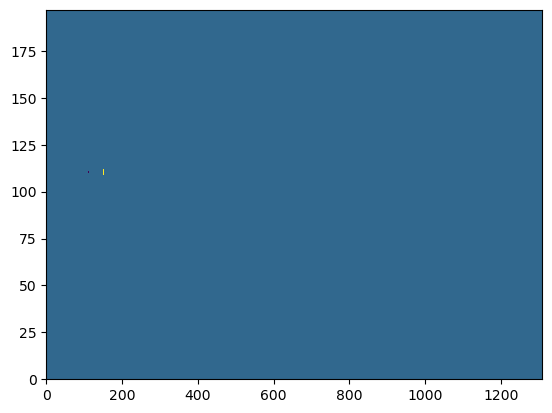

In [1475]:
plt.pcolormesh(test)

In [1476]:
def cw2d_NEW(f, dx, dy, dj=1./12, start=15, J=-1, wavelet=Mexican_hat()):

    if start:
        s0 = start / wavelet.flambda()  # user-defined start scale
    else:
        print('No start scale given, set to 2*dx')
        s0 = 2 * res / wavelet.flambda()  # default start scale: 2 * dx

    a = s0 * 2. ** (np.arange(0, J + 1) * dj)  # The scales in wavelet space ('wavelet scale')
    freqs = 1. / (wavelet.flambda() * a)  # As of Mallat 1999

    period = 1. / freqs
    real_scales = a * wavelet.flambda()#period/2. #(period/3)*2 # # 'real' scale approximation, alternative: (period/3)*2
    
    dani_scales = period/2
    
    n0, m0 = f.shape
    if s0 == -1: s0 = 2 * max(dx,dy) / wavelet.flambda()  # Smallest resolvable scale
    if J == -1: J = int(log2(max(n0,m0) * max(dx,dy) / s0) / dj)  # Number of scales
    N, M = 2 ** int(ceil(log2(n0))), 2 ** int(ceil(log2(m0)))   # Next higher power of 2
    
    a = s0 * 2. ** (arange(0, J+1) * dj)         # The scales
    A = len(a)

    # Calculates the zonal and meridional wave numbers.
    l, k = 2 * pi * fftfreq(N, dy), 2 * pi * fftfreq(M, dx)
    # Calculates the Fourier transform of the input signal.
    f_ft = fft2(f, s=(N, M))
    # Creates empty wavelet transform array and fills it for every discrete
    # scale using the convolution theorem.
    Wf = zeros((A, N, M), 'complex')
    for i, an in enumerate(a):
        psi_ft_bar = an * wavelet.psi_ft(an * k, an * l)
        Wf[i, :, :] = ifft2(f_ft * psi_ft_bar, s=(N, M))

    return Wf[:, :n0, :m0], a, freqs, real_scales, dani_scales

In [1477]:
wav_new, wscales_new, freqs_new, rscales_new, dani_scales = cw2d_NEW(test, 5, 5, dj=0.25, start=5, J=33,wavelet=Mexican_hat())
rscales_new

array([   5.        ,    5.94603558,    7.07106781,    8.40896415,
         10.        ,   11.89207115,   14.14213562,   16.81792831,
         20.        ,   23.7841423 ,   28.28427125,   33.63585661,
         40.        ,   47.5682846 ,   56.56854249,   67.27171322,
         80.        ,   95.1365692 ,  113.13708499,  134.54342644,
        160.        ,  190.2731384 ,  226.27416998,  269.08685288,
        320.        ,  380.5462768 ,  452.54833996,  538.17370576,
        640.        ,  761.0925536 ,  905.09667992, 1076.34741152,
       1280.        , 1522.1851072 ])

In [1478]:
wav_new = np.real(wav_new)
#wav_new[wav_new<0] = 0

In [1479]:
rmax = np.unravel_index(np.argmax(wav_new), wav_new.shape)

In [1480]:
rscales_new[rmax[0]]


23.78414230005442

In [1481]:
dani_scales[rmax[0]]

11.89207115002721

In [1482]:
dani_scales

array([  2.5       ,   2.97301779,   3.53553391,   4.20448208,
         5.        ,   5.94603558,   7.07106781,   8.40896415,
        10.        ,  11.89207115,  14.14213562,  16.81792831,
        20.        ,  23.7841423 ,  28.28427125,  33.63585661,
        40.        ,  47.5682846 ,  56.56854249,  67.27171322,
        80.        ,  95.1365692 , 113.13708499, 134.54342644,
       160.        , 190.2731384 , 226.27416998, 269.08685288,
       320.        , 380.5462768 , 452.54833996, 538.17370576,
       640.        , 761.0925536 ])

In [1483]:
rscales_new

array([   5.        ,    5.94603558,    7.07106781,    8.40896415,
         10.        ,   11.89207115,   14.14213562,   16.81792831,
         20.        ,   23.7841423 ,   28.28427125,   33.63585661,
         40.        ,   47.5682846 ,   56.56854249,   67.27171322,
         80.        ,   95.1365692 ,  113.13708499,  134.54342644,
        160.        ,  190.2731384 ,  226.27416998,  269.08685288,
        320.        ,  380.5462768 ,  452.54833996,  538.17370576,
        640.        ,  761.0925536 ,  905.09667992, 1076.34741152,
       1280.        , 1522.1851072 ])

In [1484]:
rmax[0]

9

In [1485]:
np.sum(wav_new[12,110,:]>0.01)

21

In [1472]:
### Interesting, Dani period/2 gives the correct scale for maximum wavelet coefficient value, so this is what to use to identify the dominate scale (comparing maximum across all scales).
### But the power field regarding values >0 is much closer to the effective scale for the power field at scale/2 (e.g. max power at 50km means power field >0 for 25km.)
## THIS IS ALSO ONLY TRUE FOR LARGE SCALES, SMALL SCALES WORK WELL WITH PERIOD/2. SMALL = < 40km
pos = np.argmin(wav_new[17,110,:][wav_new[17,110,:]>=0])

(75.0, 170.0)

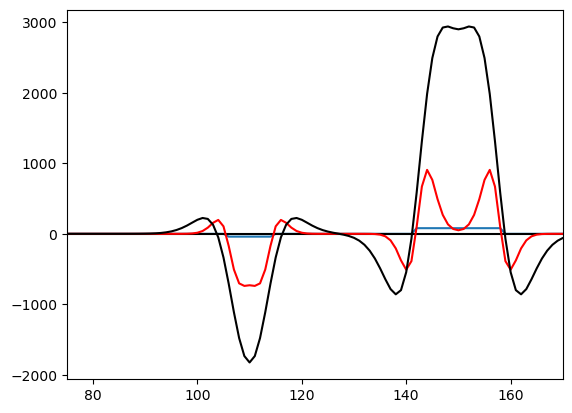

In [1473]:
f = plt.figure()
ax = f.add_subplot(111)

plt.plot(test[110,:])
ax.axhline(0, color='k')
#plt.plot(wav_real[2,50,:], 'b', linestyle='dashed')
plt.plot(np.sum(wav_new[10:14,110,:],axis=0),'r')
plt.plot(np.sum(wav_new[14:18,110,:],axis=0),'k')
ax.set_xlim(75,170)

In [1067]:
def icwt2d_new(W, a, dx, dy, dj, wavelet=Mexican_hat(), individual=False):
    """
    Inverse bi-dimensional continuous wavelet transform as in Wang and
    Lu (2010), equation [5].
    PARAMETERS
        W (array like):
            Wavelet transform, the result of the cwt2d function.
        a (array like, optional):
            Scale parameter array.
        w (class, optional) :
            Mother wavelet class. Default is Mexican_hat()
    RETURNS
        iW (array like) :
            Inverse wavelet transform.
    EXAMPLE
    """
    m0, l0, k0 = W.shape
    if m0 != a.size:
        raise Warning('Scale parameter array shape does not match wavelet' \
                       ' transform array shape.')
    # Calculates the zonal and meridional wave numters.
    L, K = 2 ** int(ceil(log2(l0))), 2 ** int(ceil(log2(k0)))
    # Calculates the zonal and meridional wave numbers.
    l, k = fftfreq(L, dy), fftfreq(K, dx)
    # Creates empty inverse wavelet transform array and fills it for every 
    # discrete scale using the convolution theorem.
    iW = zeros((m0, L, K), 'complex')
    for i, an in enumerate(a):
        psi_ft_bar = an * wavelet.psi_ft(an * k, an * l)
        W_ft = fft2(W[i, :, :], s=(L, K))
        iW[i, :, :] = ifft2(W_ft * psi_ft_bar, s=(L, K)) * wavelet.cdelta / an ** 2.
        
    if individual:
        out_iW = iW[:, :l0, :k0].real
    else:
        out_iW = iW[:, :l0, :k0].real.sum(axis=0)

    return out_iW

In [1068]:
w_in = wav_new
signal = icwt2d_new(w_in, wscales_new, 5, 5, 0.2, wavelet=Mexican_hat())

In [1069]:
rscales_new

array([  5.        ,   5.94603558,   7.07106781,   8.40896415,
        10.        ,  11.89207115,  14.14213562,  16.81792831,
        20.        ,  23.7841423 ,  28.28427125,  33.63585661,
        40.        ,  47.5682846 ,  56.56854249,  67.27171322,
        80.        ,  95.1365692 , 113.13708499, 134.54342644,
       160.        , 190.2731384 , 226.27416998, 269.08685288,
       320.        , 380.5462768 , 452.54833996, 538.17370576,
       640.        , 761.0925536 , 905.09667992])

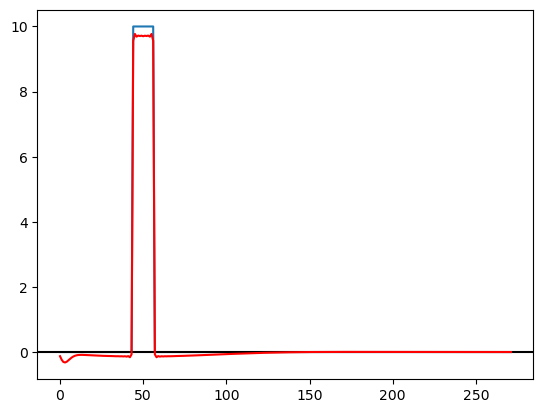

In [1070]:
f = plt.figure()
ax = f.add_subplot(111)

plt.plot(test[50,:])
ax.axhline(0, color='k')
plt.plot(signal[50,:],'red')

In [1071]:
wav_SM, wscales_SM, freqs_SM, rscales_SM = cw2d_NEW(odat[:,600::], 5, 5, dj=0.25, start=5, J=40, wavelet=Mexican_hat())

New s0 1.258230302612176
freqs [2.00000000e-01 1.68179283e-01 1.41421356e-01 1.18920712e-01
 1.00000000e-01 8.40896415e-02 7.07106781e-02 5.94603558e-02
 5.00000000e-02 4.20448208e-02 3.53553391e-02 2.97301779e-02
 2.50000000e-02 2.10224104e-02 1.76776695e-02 1.48650889e-02
 1.25000000e-02 1.05112052e-02 8.83883476e-03 7.43254447e-03
 6.25000000e-03 5.25560260e-03 4.41941738e-03 3.71627223e-03
 3.12500000e-03 2.62780130e-03 2.20970869e-03 1.85813612e-03
 1.56250000e-03 1.31390065e-03 1.10485435e-03 9.29068059e-04
 7.81250000e-04 6.56950324e-04 5.52427173e-04 4.64534029e-04
 3.90625000e-04 3.28475162e-04 2.76213586e-04 2.32267015e-04
 1.95312500e-04]
newwscales [1.25823030e+00 1.49629643e+00 1.77940636e+00 2.11608270e+00
 2.51646061e+00 2.99259286e+00 3.55881272e+00 4.23216540e+00
 5.03292121e+00 5.98518571e+00 7.11762543e+00 8.46433081e+00
 1.00658424e+01 1.19703714e+01 1.42352509e+01 1.69286616e+01
 2.01316848e+01 2.39407429e+01 2.84705017e+01 3.38573232e+01
 4.02633697e+01 4.78814857

In [1072]:
rscales_SM

array([5.00000000e+00, 5.94603558e+00, 7.07106781e+00, 8.40896415e+00,
       1.00000000e+01, 1.18920712e+01, 1.41421356e+01, 1.68179283e+01,
       2.00000000e+01, 2.37841423e+01, 2.82842712e+01, 3.36358566e+01,
       4.00000000e+01, 4.75682846e+01, 5.65685425e+01, 6.72717132e+01,
       8.00000000e+01, 9.51365692e+01, 1.13137085e+02, 1.34543426e+02,
       1.60000000e+02, 1.90273138e+02, 2.26274170e+02, 2.69086853e+02,
       3.20000000e+02, 3.80546277e+02, 4.52548340e+02, 5.38173706e+02,
       6.40000000e+02, 7.61092554e+02, 9.05096680e+02, 1.07634741e+03,
       1.28000000e+03, 1.52218511e+03, 1.81019336e+03, 2.15269482e+03,
       2.56000000e+03, 3.04437021e+03, 3.62038672e+03, 4.30538965e+03,
       5.12000000e+03])

In [1073]:
SM_signal = icwt2d_new(wav_SM, wscales_SM, 5, 5, 5, wavelet=Mexican_hat())

PearsonRResult(statistic=0.9767489369244837, pvalue=0.0)
Mean abs error: 0.645658758499868


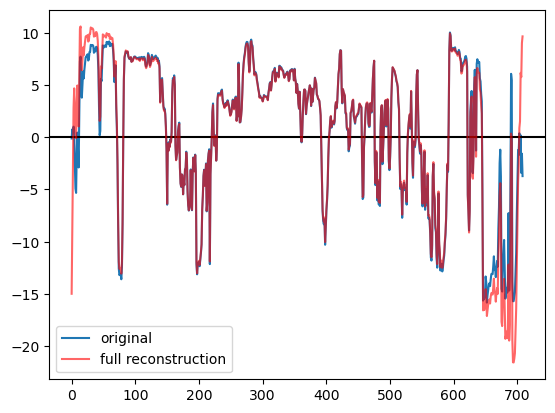

In [1074]:
idx = 110
f = plt.figure()
ax = f.add_subplot(111)

plt.plot(odat[idx,600::], label='original')
ax.axhline(0, color='k')
plt.plot(SM_signal[idx,:],'red', alpha=0.6, label='full reconstruction')

print(stats.pearsonr(odat[idx,600::], SM_signal[idx,:]))
print('Mean abs error:', mae(odat[idx,600::], SM_signal[idx,:]))
plt.legend()

In [1075]:
SM_signal_scale = icwt2d_new(wav_SM, wscales_SM, 5, 5, 5, wavelet=Mexican_hat(), individual=True)

PearsonRResult(statistic=0.9767489369244837, pvalue=0.0)


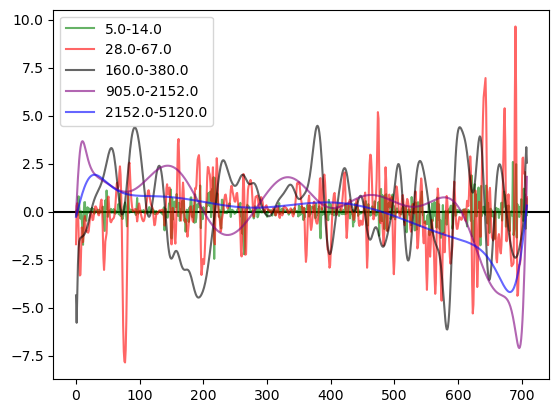

In [1143]:
idx = 110

cs = ['green','red', 'k', 'purple','blue']

f = plt.figure()
ax = f.add_subplot(111)
ax.axhline(0, color='k')
for six, si in enumerate([1,10,20,30,-6]):
    plt.plot(SM_signal_scale[si:si+5,idx,:].sum(axis=0), alpha=0.6, color=cs[six], label = str(np.floor(rscales_SM[si]))+'-'+str(np.floor(rscales_SM[si+5])))
plt.legend()
print(stats.pearsonr(odat[idx,600::], SM_signal[idx,:]))